# Playground

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

In [5]:
from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict

import pandas as pd
import seaborn as sns
import numpy as np

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader, Dataset

from gmfpp.utils.data_preparation import *
from gmfpp.utils.data_transformers import *
from gmfpp.utils.plotting import *
from gmfpp.utils.training import *

from gmfpp.models.ReparameterizedDiagonalGaussian import *
from gmfpp.models.CytoVariationalAutoencoder import *
from gmfpp.models.VariationalAutoencoder import *
from gmfpp.models.ConvVariationalAutoencoder import *
from gmfpp.models.VariationalInference import *
from gmfpp.models.LoadModels import *

In [6]:
constant_seed()

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Load data

In [8]:
metadata_all = read_metadata("./data/all/metadata.csv")
metadata_all = shuffle_metadata(metadata_all)

In [9]:
metadata = metadata_all[:2000]

In [10]:
metadata = shuffle_metadata(metadata)
metadata_train, metadata_validation = split_metadata(metadata, split_fraction = .90)

In [11]:
relative_path = get_relative_image_paths(metadata)
image_paths = ["./data/all/" + path for path in relative_path]

In [12]:
images = load_images(image_paths, verbose=True, log_every=10000)

12:12:55 | loaded 0/2000 images (0.00%).
12:13:00 | loaded 2000/2000 images (100.00%).


## Normalize data

In [13]:
normalize_every_image_channels_seperately_inplace(images)
#normalize_channels_inplace(images)

In [14]:
channel_first = view_channel_dim_first(images)
for i in range(channel_first.shape[0]):
    channel = channel_first[i]
    print("channel {} interval: [{:.2f}; {:.2f}]".format(i, torch.min(channel), torch.max(channel)))

channel 0 interval: [0.02; 1.00]
channel 1 interval: [0.01; 1.00]
channel 2 interval: [0.01; 1.00]


## Prepare datasets

In [15]:
class SingleCellDataset(Dataset):
    
    def __init__(self, metadata: pd.DataFrame, images: torch.Tensor, label_to_id: Dict[str, int]):
        self.metadata = metadata
        self.label_to_id = label_to_id
        self.images = images
        
    def __len__(self):
        return self.metadata.shape[0]

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        
        image_id = row.name
        image = self.images[image_id]
        
        label_name = row["moa"]
        label = self.label_to_id[label_name]
        
        return image.detach(), label

In [16]:
mapping = get_MOA_to_id()
train_set = SingleCellDataset(metadata_train, images, mapping)
validation_set = SingleCellDataset(metadata_validation, images, mapping)

In [17]:
len(train_set)

1801

## VAE

In [247]:
# start another training session
vae, validation_data, training_data, VAE_settings = initVAEmodel(latent_features= 256,
                                                                    beta = 1.,
                                                                    num_epochs = 1000,
                                                                    batch_size = min(32, len(train_set)),
                                                                    learning_rate = 1e-3,
                                                                    weight_decay = 10e-4,
                                                                    image_shape = np.array([3, 68, 68]))

In [20]:
#Or load an old
#vae, validation_data, training_data, VAE_settings = LoadVAEmodel("model_dump", '2022-11-21 - 13-30-35')
#vae, validation_data, training_data, VAE_settings = LoadVAEmodel("./model_dump", '2022-11-25 - 06-53-47')
#vae, validation_data, training_data, VAE_settings = LoadVAEmodel("./model_dump", '2022-11-25 - 16-43-05')
vae, validation_data, training_data, VAE_settings = LoadVAEmodel("./pretrained", '2022-11-25 - 20-36-12')
#vae, validation_data, training_data, VAE_settings = LoadVAEmodel("./pretrained", '2022-11-25 - 21-21-46')

In [21]:
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=VAE_settings['learning_rate'], weight_decay=VAE_settings['weight_decay'])

vi = VariationalInference(beta=VAE_settings['beta'])

In [22]:
train_loader = DataLoader(train_set, batch_size=VAE_settings['batch_size'], shuffle=True, num_workers=0, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=len(validation_set), shuffle=False, num_workers=0, drop_last=False)
train_batcher = TreatmentBalancedBatchGenerator(images, metadata_train)

## Unbalanced training

In [ ]:
print_every = 10

num_epochs = VAE_settings['num_epochs']
batch_size = VAE_settings['batch_size']

for epoch in range(num_epochs):

    training_epoch_data = defaultdict(list)
    
    vae.train()

    for x, _ in train_loader:
        x = x.to(device)
        
        loss, diagnostics, outputs = vi(vae, x)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(vae.parameters(), 10_000)
        optimizer.step()

        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]


    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    with torch.no_grad():
        vae.eval()
        
        validation_epoch_data = defaultdict(list)
        
        for x, _ in validation_loader:
            x = x.to(device)
          
            loss, diagnostics, outputs = vi(vae, x)
            
            for k, v in diagnostics.items():
                validation_epoch_data[k] += [v.mean().item()]

        for k, v in diagnostics.items():
            validation_data[k] += [np.mean(validation_epoch_data[k])]
        
    if epoch % print_every == 0:
        print(f"epoch: {epoch}/{num_epochs}")  
        print("training | elbo: {:2f}, log_px: {:.2f}, kl: {:.2f}:".format(np.mean(training_epoch_data["elbo"]), np.mean(training_epoch_data["log_px"]), np.mean(training_epoch_data["kl"])))
        print("validation | elbo: {:2f}, log_px: {:.2f}, kl: {:.2f}:".format(np.mean(validation_data["elbo"]), np.mean(validation_data["log_px"]), np.mean(validation_data["kl"])))    


## Balanced treatment training

In [257]:
iterations = 10_000

validate_every = 100

for iteration in range(iterations):
    x, _ = train_batcher.next_batch()
    
    vae.train()
    
    loss, diagnostics, outputs = vi(vae, x)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(vae.parameters(), 10_000)
    optimizer.step()
    
    if iteration % validate_every == 0:
        with torch.no_grad():
            vae.eval()

            validation_epoch_data = defaultdict(list)

            for x, _ in validation_loader:
                x = x.to(device)

                loss, diagnostics, outputs = vi(vae, x)

                for k, v in diagnostics.items():
                    validation_epoch_data[k] += [v.mean().item()]

            for k, v in diagnostics.items():
                validation_data[k] += [np.mean(validation_epoch_data[k])]
        
        print(f"iteration: {iteration}/{iterations}")  
        print("validation | elbo: {:2f}, log_px: {:.2f}, kl: {:.2f}:".format(np.mean(validation_data["elbo"]), np.mean(validation_data["log_px"]), np.mean(validation_data["kl"])))    

iteration: 0/10000
validation | elbo: -14555.131836, log_px: -14550.95, kl: 4.19:
iteration: 100/10000
validation | elbo: -14049.509115, log_px: -14010.97, kl: 38.54:
iteration: 200/10000
validation | elbo: -13733.474121, log_px: -13681.48, kl: 51.99:
iteration: 300/10000
validation | elbo: -13468.532031, log_px: -13413.07, kl: 55.46:
iteration: 400/10000
validation | elbo: -13196.886230, log_px: -13140.60, kl: 56.29:
iteration: 500/10000
validation | elbo: -12888.962054, log_px: -12833.34, kl: 55.62:
iteration: 600/10000
validation | elbo: -12522.119385, log_px: -12467.86, kl: 54.26:
iteration: 700/10000
validation | elbo: -12087.398329, log_px: -12033.78, kl: 53.62:
iteration: 800/10000
validation | elbo: -11577.295410, log_px: -11524.09, kl: 53.21:
iteration: 900/10000
validation | elbo: -11000.238636, log_px: -10946.34, kl: 53.90:
iteration: 1000/10000
validation | elbo: -10357.081299, log_px: -10301.88, kl: 55.20:
iteration: 1100/10000
validation | elbo: -9662.256442, log_px: -960

KeyboardInterrupt: 

In [214]:
treatment_indices = get_treatment_indices(metadata)

batcher = TreatmentBalancedBatchGenerator(treatment_indices, images, metadata)

In [ ]:
print(VAE_settings)

In [ ]:
######### Save VAE parameters #########
cprint("Save VAE parameters")
create_directory("dump/parameters")
datetime = get_datetime()
torch.save(vae.state_dict(), "dump/parameters/vae_parameters_{}.pt".format(datetime))
torch.save(validation_data, "dump/parameters/validation_data_{}.pt".format(datetime))
torch.save(training_data, "dump/parameters/training_data_{}.pt".format(datetime))
torch.save(VAE_settings, "dump/parameters/VAE_settings_{}.pt".format(datetime))

In [ ]:
plot_VAE_performance(**training_data, file='dump/images/training_data.png', title='VAE - learning')
plot_VAE_performance(**validation_data, file='dump/images/validation_data.png', title='VAE - validation')

## Compare reconstruction and original image

In [23]:
x, _ = train_set[0]

In [24]:
x.shape

torch.Size([3, 68, 68])

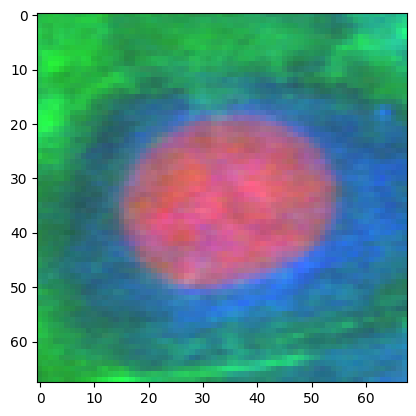

In [25]:
plot_image(img_saturate(x))

In [110]:
def sample_reconstruction_distribution_from_latent(vae: nn.Module, latent: torch.Tensor):
    vae.eval()
    px = vae.observation_model(latent)
    x_reconstruction = px.sample()
    return x_reconstruction

In [111]:
def sample_decoder_distribution_from_latent(vae: nn.Module, latent: torch.Tensor) -> torch.Tensor:
    vae.eval()
    px = vae.observation_model(latent)
    return px.mean.detach()[0]

In [112]:
def sample_decoder_distribution_from_image(vae: nn.Module, image: torch.Tensor) -> torch.Tensor:
    vae.eval()
    outputs = vae(image)
    px = outputs["px"]
    return px.mean.detach()[0]

In [113]:
def sample_reconstruction_distribution_from_image(vae: nn.Module, image: torch.Tensor) -> torch.Tensor:
    vae.eval()
    outputs = vae(image)
    px = outputs["px"]
    reconstruction = px.sample()
    return reconstruction[0]

In [114]:
random_latent = np.random.normal(1, size=256).astype(np.float32)
random_latent = torch.from_numpy(0.1 * random_latent[None])
x_reconstruction = sample_decoder_distribution_from_latent(vae, random_latent)

In [117]:
x_reconstruction = sample_from_decoder(vae, x[None,:,:,:])

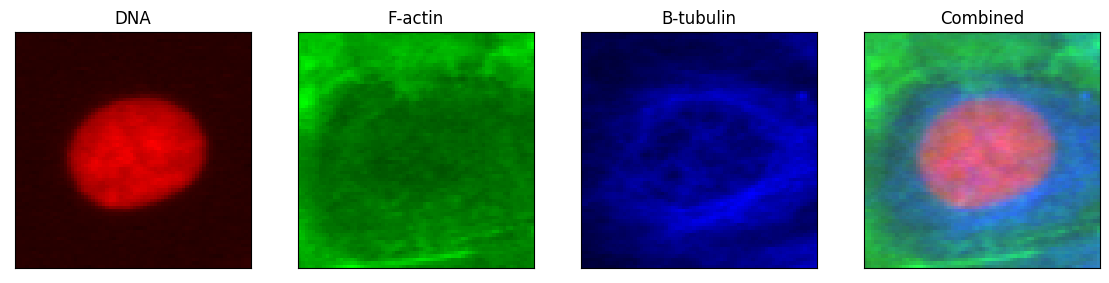

In [118]:
plot_image_channels(img_saturate(x))

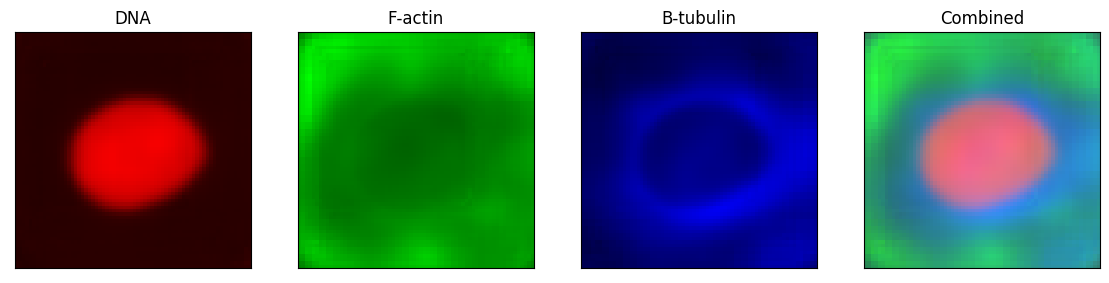

In [119]:
plot_image_channels(img_saturate(x_reconstruction))

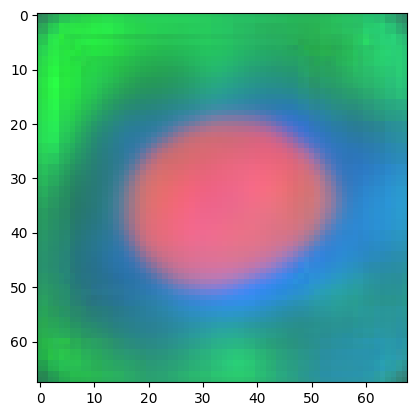

In [120]:
plot_image(img_saturate(clip_image_to_zero_one(x_reconstruction)))

In [ ]:
n = 3
for i in range(n):
    x, y = train_set[i]    
    #x = x.to(device)
    
    plot_image_channels(x, file="dump/images/x_{}.png".format(i))
   
    outputs = vae(x[None,:,:,:])
    px = outputs["px"]
    
    x_reconstruction = px.sample()
    x_reconstruction = x_reconstruction[0]
    plot_image_channels(img_saturate(x_reconstruction))


## Downstream Classification

In [ ]:
def get_plate_and_well_indices(metadata: pd.DataFrame) -> Dict[str, list]:
    plates_and_wells = np.array(metadata[['Image_Metadata_Plate_DAPI','Image_Metadata_Well_DAPI']])
    result = defaultdict(list)

    for i in range(plates_and_wells.shape[0]):
        plate, well = plates_and_wells[i]
        result[(plate, well)] += [i]
        
    return result

In [ ]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, n_classes: int = 13):
        super(NeuralNetwork, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes))

    def forward(self, x):
        logits = self.net(x)
        return logits

    
N_classes = len(mapping)
classifier = NeuralNetwork(N_classes).to(device)
print(classifier)

In [ ]:
# VAE
image_shape = np.array([3, 68, 68])
latent_features = 256
vae = CytoVariationalAutoencoder(image_shape, latent_features).to(device) # @TODO: load trained parameters

In [ ]:
def extract_well_metadata(metadata: pd.DataFrame, plate_and_well_indices: Dict[Tuple[str, str], list]) -> pd.DataFrame:
    data = defaultdict(list)

    for plate_and_well in plate_and_well_indices:
        indices = plate_and_well_indices[plate_and_well]
        index = indices[0] # just use the first sample, since they all have undergone the same treatment

        row = metadata.loc[index]
        
        plate, well = plate_and_well
        
        data["Image_Metadata_Plate_DAPI"] += [plate]
        data["Image_Metadata_Well_DAPI"] += [well]
        data["Image_Metadata_Compound"] += [row["Image_Metadata_Compound"]]
        data["Image_Metadata_Concentration"] += [row["Image_Metadata_Concentration"]]
        data["moa"] += [row["moa"]]

    well_metadata = pd.DataFrame(data)
        
    return well_metadata

In [ ]:
def get_well_profiles(vae: nn.Module, metadata: pd.DataFrame, images: torch.Tensor) -> torch.Tensor:
    plate_and_well_indices = get_plate_and_well_indices(metadata)
    well_metadata = extract_well_metadata(metadata, plate_and_well_indices)
    
    well_profiles = torch.empty((len(plate_and_well_indices), vae.latent_features))
    
    batch_size = 64 # we need to batch them to handle memory issues...
    
    with torch.no_grad():
        vae.eval()
        
        for i, plate_and_well in enumerate(plate_and_well_indices):
            indices = plate_and_well_indices[plate_and_well]
            x = images[indices]
            x = x.to(device)

            z = torch.zeros(vae.latent_features)

            batch_offset = np.arange(start=0, stop=len(x), step=batch_size)
            for j in range(batch_offset.shape[0] - 1):
                start = batch_offset[j]
                end = batch_offset[j+1]

                outputs = vae(x[start:end])
                z += torch.sum(outputs["z"])

            # last batch
            outputs = vae(x[batch_offset[-1]:])   
            z += torch.sum(outputs["z"])

            well_profiles[i] = z.detach().cpu() / len(indices)
        
    return well_profiles, well_metadata

In [ ]:
%%time
well_profiles, well_metadata = get_well_profiles(vae, metadata, images)

In [ ]:
well_metadata.head()

In [ ]:
def count_num_correct(y_pred, y_true):
    return torch.sum(y_pred == y_true).item()

In [ ]:
# Classifier
N_classes = len(mapping)
classifier = NeuralNetwork(N_classes).to(device)

# Training
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-2)

num_epochs = 10
batch_size = 32

In [ ]:
def extract_metadata_with_compound(metadata: pd.DataFrame, compound: str) -> pd.DataFrame:
    return metadata[metadata["Image_Metadata_Compound"] == compound]

In [ ]:
def remove_metadata_subset(metadata: pd.DataFrame, subset: pd.DataFrame) -> pd.DataFrame:
    return metadata[~metadata.index.isin(subset.index)]

In [ ]:
metadata_test = extract_metadata_with_compound(well_metadata, "taxol")
metadata_train_all = remove_metadata_subset(well_metadata, metadata_test)
metadata_train, metadata_validation = split_metadata(metadata_train_all, split_fraction = .49)

mapping = get_MOA_to_id()
train_set = SingleCellDataset(metadata_train, well_profiles, mapping)
validation_set = SingleCellDataset(metadata_validation, well_profiles, mapping)
test_set = SingleCellDataset(metadata_test, well_profiles, mapping)

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0, drop_last=False)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=0, drop_last=False)

In [ ]:
train_loss = []
train_accuracy = []

validation_loss = []
validation_accuracy = []

for epoch in range(num_epochs):
    print(f"epoch: {epoch}/{num_epochs}")    

    train_epoch_loss = []
    train_epoch_accuracy = []
    
    classifier.train()
    
    train_correct = 0
    train_num_predictions = 0
    
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        prediction_prob = classifier(x)
        loss = loss_fn(prediction_prob, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        N = len(x)
        train_num_predictions += N
        pred = torch.argmax(prediction_prob, dim=1)
        train_correct += count_num_correct(pred, y.detach())
        
        train_epoch_loss.append(loss.detach().item())
        
    epoch_mean_loss = np.mean(train_epoch_loss)
    train_loss.append(epoch_mean_loss)
    train_accuracy.append(train_correct / train_num_predictions)
    
    print("training | loss: {:.2f}".format(epoch_mean_loss))
    
    
    validation_epoch_loss = []
    classifier.eval()
    
    validation_correct = 0
    validation_num_predictions = 0
    
    for x, y in validation_loader:
        x = x.to(device)
        y = y.to(device)
        
        prediction_prob = classifier(x)
        loss = loss_fn(prediction_prob, y)
        
        validation_epoch_loss.append(loss.detach().item())
        
        N = len(x)
        validation_num_predictions += N
        pred = torch.argmax(prediction_prob, dim=1)
        validation_correct += count_num_correct(pred, y)

    epoch_mean_loss = np.mean(validation_epoch_loss)
    validation_loss.append(epoch_mean_loss)
    validation_accuracy.append(validation_correct / validation_num_predictions)
   
        
    print("validation | loss: {:.2f}".format(epoch_mean_loss))

In [ ]:
def plot_classifier_performance(train_loss, train_accuracy, validation_loss, validation_accuracy):
    fig, axs = plt.subplots(1, 2, figsize=(14,6), constrained_layout = True)
    fig.suptitle("Classifier - learning", fontsize=16)

    ax1 = axs[0]
    ax1.grid()
    ax1.plot(train_loss)
    ax1.plot(validation_loss)
    ax1.legend(["train", "validation"])
    ax1.set_ylabel("loss")
    ax1.set_xlabel("epoch")

    ax2 = axs[1]
    ax2.grid()
    ax2.plot(train_accuracy)
    ax2.plot(validation_accuracy)
    ax2.legend(["train", "validation"])
    ax2.set_ylabel("accuracy")
    ax2.set_xlabel("epoch")

In [ ]:
plot_classifier_performance(train_loss, train_accuracy, validation_loss, validation_accuracy)

## @TODO
- Look at latent representation
    - How does changing one latent variable change the image reconstruction?
    - How similiar are images in the latent space (cosine-simularity)

In [ ]:
def print_MOA_distribution(metadata: pd.DataFrame):
    moa_types = get_MOA_types()
    for moa in moa_types:
        count = np.sum(metadata["moa"] == moa)
        percentage = count / len(metadata)
        print("{} - {:.3f}".format(moa, percentage))

In [ ]:
def extract_indices_for_each_MOA(metadata: pd.DataFrame) -> Dict[str, np.ndarray]:
    moa_types = get_MOA_types()
    result = {}
    
    for moa in moa_types:
        mask = np.array(metadata["moa"] == moa)
        result[moa] = np.array(metadata.index[mask])
        
    return result

In [ ]:
def flatten_MOA_indices(moa_indices: Dict[str, np.ndarray]):
    return np.concatenate([moa_indices[moa] for moa in moa_indices])

In [ ]:
def extract_metadata_from_indices(metadata: pd.DataFrame, indices: np.ndarray) -> pd.DataFrame:
    return metadata.loc[indices]

In [ ]:
def shuffle_MOA_indices_inplace(moa_indices: Dict[str, np.ndarray]):
    for moa in moa_indices:
        np.random.shuffle(moa_indices[moa])

In [ ]:
def count_MOA_samples(metadata: pd.DataFrame):
    moa_types = get_MOA_types()
    indices = extract_indices_for_each_MOA(metadata)
    result = {}
    
    for moa in indices:
        result[moa] = indices[moa].shape[0]
        
    return result

In [ ]:
def get_MOA_types() -> List[str]:
    return list(get_MOA_to_id())

In [ ]:
class MoaBalancedBatchGenerator:
    
    def __init__(self, moa_indices: Dict[str, np.ndarray], images: torch.Tensor, metadata: pd.DataFrame, num_moa_type_per_batch: int = 1):
        self.moa_indices = moa_indices
        self.batch_size = num_moa_type_per_batch * len(moa_indices)
        self.num_moa_type_per_batch = num_moa_type_per_batch
        self.images = images
        self.metadata = metadata
    
    def next_indices(self) -> np.ndarray:
        result = np.empty(self.batch_size, dtype=np.int64)
        
        for i, moa in enumerate(moa_indices):
            pick = np.random.choice(moa_indices[moa], self.num_moa_type_per_batch, replace=False)
            
            start = i * self.num_moa_type_per_batch
            end = start + self.num_moa_type_per_batch
            result[start:end] = pick
            
        return result
    
    def __iter__(self):
        return self

    def __next__(self):
        indices = self.next_indices()
        X, y = extract_batch_from_indices(indices, self.images, self.metadata)
        return X, y

In [ ]:
def get_MOA_balanced_metadata_subset(all_metadata: pd.DataFrame, num_samples_in_each_moa: int) -> pd.DataFrame:
    moa_indices = extract_indices_for_each_MOA(all_metadata)
    
    for moa in moa_indices:
        assert len(moa_indices[moa]) >= num_samples_in_each_moa, "MOA {} has only {} samples, but asked for {} samples".format(moa, len(moa_indices[moa]), num_samples_in_each_moa)
        moa_indices[moa] = moa_indices[moa][:num_samples_in_each_moa]
    
    indices = flatten_MOA_indices(moa_indices)
    metadata = extract_metadata_from_indices(all_metadata, indices)
    
    return metadata

In [ ]:
metadata = get_MOA_balanced_metadata_subset(metadata_all, num_samples_in_each_moa=20)
metadata = metadata.reset_index(drop=True)

In [ ]:
print_MOA_distribution(metadata)

In [ ]:
metadata_test = get_MOA_balanced_metadata_subset(metadata, num_samples_in_each_moa=2)
metadata_train_all = metadata[~metadata.index.isin(metadata_test.index)]
metadata_validation = get_MOA_balanced_metadata_subset(metadata_train_all, num_samples_in_each_moa=2)
metadata_training = metadata_train_all[~metadata_train_all.index.isin(metadata_validation.index)]

In [ ]:
#moa_indices = extract_indices_for_each_MOA(metadata_training)
#shuffle_MOA_indices_inplace(moa_indices)

In [ ]:
moa_indices = extract_indices_for_each_MOA(metadata_training)
batchGenerator = MoaBalancedBatchGenerator(moa_indices, images, metadata, num_moa_type_per_batch=4)

In [ ]:
%%time
max_iterations = 80_000

i = 0
for i in range(max_iterations):
    X, y = next(batchGenerator)
    

print("done")